In [1]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 200

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "5.NetworkMetrics")

# 0. Basic Network Properties
It's important to understand the core features of the network before digging into low-level analysis through expensive algorithms. From now on, we would be referring to the terminology listed below.

We already had obtained the number of nodes $N$ and the number of links $L$ from the previous notebooks, and these two information are enough to calculate the average degree $\langle K \rangle$ as $\langle K \rangle = \frac{2L}{N}$, since the network is ***undirected***.

In [2]:
# Calculate network average degree
N = 89577277
L = 434193958
K = 2.0 * L/N
print("Average Degree is %.3f" %K)

Average Degree is 9.694


| Number of nodes ($N$) | Number of links ($L$) | Average Degree $\langle K \rangle$ |
|---|---|---|
| 89.577.277 (~90M) | 434.193.958 (~400M) | 9,694 |

# 1. Generate undirected graph with SNAP.Py
Calculating the network metrics doesn't necessarily require including edge metadata in the graph, therefore **SNAP.Py** comes handy in this case. Let's import the MMR data in an **undirected graph** data structure and build the main network.

Since SNAP.Py allows inserting vertices by specifying a **node ID**, I don't need to read the `usernames.csv` file, since all IDs from 0 to $(N-1)$ are existing for sure, where $N=89.577.277$. By the other hand, I may read the edges from the `mmr_encoded_final.csv` file and ignore the edge metadata column including the periods array.

In [3]:
def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')

# We ignore prop for the moment
def process_edge_line(line):
    source, target, prop = line.split(',')
    return int(source), int(target)

def build_mmr_graph():
    # Create main graph object
    graph = TUNGraph.New()

    # First add vertices
    print("Adding vertices...")
    for i in xrange(0, N):
        graph.AddNode(i)
    print("Done adding vertices, now adding links...")

    # Add links by reading them from MMR data file
    with open(os.path.join(data_dir,"mmr_encoded_final.csv")) as io:
        counter = 0
        for line in read_large_file(io):
            source, target = process_edge_line(line)
            graph.AddEdge(source, target)
            counter += 1
            if counter % 50000000 == 0:
                print("Added %d links..." %counter)
        print("Done! Total links: %d" %counter)
        assert counter == L
    return graph

In [4]:
%%time
graph = build_mmr_graph()

Adding vertices...
Done adding vertices, now adding links...
Added 50000000 links...
Added 100000000 links...
Added 150000000 links...
Added 200000000 links...
Added 250000000 links...
Added 300000000 links...
Added 350000000 links...
Added 400000000 links...
Done! Total links: 434193958
CPU times: user 25min 3s, sys: 14.4 s, total: 25min 17s
Wall time: 25min 14s


In [5]:
%%time
# Create binary backup of original MMR graph, for easy re-import
FOut = snap.TFOut("../data/mmr_original.bin")
graph.Save(FOut)
FOut.Flush()

CPU times: user 24.8 s, sys: 3.19 s, total: 28 s
Wall time: 28 s


Building the whole MMR graph takes ~30 minutes, which is quite reasonable. Let's check how much is the currently consumed memory:

In [6]:
%%bash
free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         16G         43G        108M         65G        108G
Swap:           63G        621M         63G


The whole graph loaded in memory takes *less than 16GB* of RAM, which is significantly uncomparable with NetworkX's performance.

# 2. Degree Distribution and Node Degrees
SNAP.Py comes with a built-in function to calculate the histogram values needed to plot the degree distribution. The output variable, `DegToCntV`, is a vector of pairs such that the first element indicates the $x$-axis value ($k$ = degree), and the second one the $y$-axis value (number of degree-$k$ nodes). In order to represent $p_k$, which is a probability hence whose values range in the interval $[0,1]$, I have to normalize it: $p_k=\frac{N_k}{N}$, where $N_k$ is the number of degree-$k$ nodes.

The degree distribution represents a core feature for network analysis, because it explains what is the probability $p_k$ that, given a random node, it has degree $k$. Furthermore, $p_k$ determines many network phenomena such as network robustness.

In [7]:
%%time

def calculate_degree_distribution(graph):
    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(graph, DegToCntV)
    return DegToCntV

DegToCntV = calculate_degree_distribution(graph)

CPU times: user 1.97 s, sys: 4 ms, total: 1.97 s
Wall time: 1.97 s


Execution time above points out the impressive performance of SNAP.Py even with large-scale networks over Neo4j and NetworkX.

I hereby plot the degree distribution both in regular scale and logarithmic scale.

In [8]:
def get_deg_dist_variables_to_plot(DegToCntV):
    x = [item.GetVal1() for item in DegToCntV]
    y = [item.GetVal2() * 1.0 / N for item in DegToCntV]
    print("Min Degree: %d\nMax Degree: %d\n" %(min(x), max(x)))
    print("Min p(k): %.15f\nMax p(k): %.15f" %(min(y), max(y)))
    return x,y

In [9]:
x, y = get_deg_dist_variables_to_plot(DegToCntV)

Min Degree: 1
Max Degree: 41359

Min p(k): 0.000000011163545
Max p(k): 0.326320502017493


In [11]:
def plot_degree_distribution(x,y,fig_filename):
    plt.figure(figsize=(16,6))

    # First subplot: normal axes
    plt.subplot(1,2,1)
    plt.xlabel("K (Degree)")
    plt.ylabel("Probability of K-degree")
    plt.plot(x,y,"r.")
    plt.title("Degree Distribution", fontsize=16)

    # Second subplot: logarithmic axes
    plt.subplot(1,2,2)
    plt.xlabel("K (Degree) (log)")
    plt.ylabel("Probability of K-degree (log)")
    plt.loglog(x, y, "r.")
    plt.title("Degree Distribution (Logarithmic Axes)", fontsize=16)
    
    # Save and show figure
    plt.savefig(os.path.join(pictures_path,fig_filename))
    plt.show()

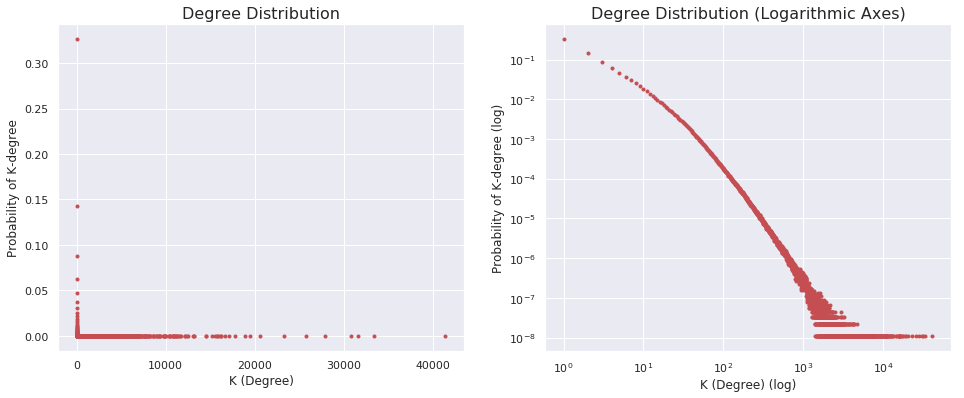

In [11]:
plot_degree_distribution(x, y, "degree_distribution_1.png")

At first sight, the distribution plotted with regular scale doesn't seem very meaningful, and the reason is easily arguable: our MMR graph has nodes whose degrees range in $1 \leq k \leq 41359$, whereas the values of the probability range in $0 \lt p_k \leq 0.326$. By looking at the plot, it's easy to infer that more than ${1/3}$ of the nodes have only one link, and the probability of having more than one link decreases exponentially. Here the logarithmic scale becomes convenient, because it better highlights this phenomenon which is typical of those networks known as ***scale-free networks***. A scale-free network, indeed, is defined as such when its degree distribution follows (at least asymptotically) a **power law**.

## 2.1 Usernames with highest $k$
I wanted to investigate which Twitter usernames actually correspond to those nodes with extremely high degree.

In [12]:
n_id_max_deg = snap.GetMxDegNId(graph)
print("The node with the highest degree has ID %d" %n_id_max_deg)

The node with the highest degree has ID 54790022


In [13]:
%%bash
../scripts/get_username.sh 54790022

cocanomc,54790022


SNAP.Py comes with a built-in function to calculate the In/Out degree of every node in the graph (`GetNodeInDegV` / `GetNodeOutDegV`). Since our graph is undirected, any function would suit fine.

In [36]:
%%time

InDegV = snap.TIntPrV()
snap.GetNodeInDegV(graph, InDegV)
node_degrees = [(item.GetVal1(), item.GetVal2()) for item in InDegV]

# Sort list by degree
node_degrees = sorted(node_degrees, key=operator.itemgetter(1))

CPU times: user 3min 25s, sys: 9.43 s, total: 3min 34s
Wall time: 3min 28s


Let's show who are the top 20 nodes with the highest degree and try to figure out if any of them correspond to any well known Twitter username. The previously created `get_username.sh` bash script is convenient when I need to lookup for a single value, but running it several times might be time consuming. Hereby the function that should be preferred when multiple lookups are needed:

In [141]:
# %load ../scripts/def_get_multiple_usernames.py
def get_multiple_usernames(ids):
    # Convert ID to line number by adding 1
    arg = ";".join([str(el + 1) + "p" for el in ids])

    #Invoke shell script that finds the occurrences
    p = subprocess.Popen(['../scripts/get_usernames.sh', arg], stdout=subprocess.PIPE)
    output = p.communicate()[0]

    id_to_username_dict = {line.split(',')[1]:line.split(',')[0] for line in output.split('\n') if line != ""}
    return id_to_username_dict

In [150]:
%%time
data = sorted(node_degrees[-20:], key=operator.itemgetter(1), reverse=True)
node_ids = [el[0] for el in data]
id_to_username_dict = get_multiple_usernames(node_ids)

CPU times: user 0 ns, sys: 392 ms, total: 392 ms
Wall time: 15.7 s


In [210]:
def show_data_as_dataframe(data, column_labels):
    df = pd.DataFrame(data, columns=column_labels)
    display(df)
    return df

In [151]:
# Show data formatted as DataFrame
data = [[id_to_username_dict[str(el[0])], el[0], el[1]] for el in data]
show_data_as_dataframe(data, ["Username", "Node ID (Encoding)", "Degree"])

,Username,Node ID (Encoding),Degree
0,cocanomc,54790022,41359
1,telkomsel,61888,33341
2,stccare,272020,31578
3,virginmedia,113519,30738
4,xboxsupport,112622,27853
5,americanair,38831,25676
6,atviassist,13925,23270
7,tesco,34364,20606
8,btcare,46286,19399
9,indosatcare,64396,18911


The results shown above show one of the first issues with the collected data, since it was not subject to any data-cleaning process before the analysis. By individually checking all the Twitter usernames listed above, it's easy to infer that they all correspond to famous, large-scale companies that use Twitter as a social media platform to get in touch with their customers, often through *customer technical support* inquiries. This explains their huge degree value (as of now, they're basically **network hubs**), but at the same times it represents a downside for our analysis since their connections are more likely not to be very meaningful.

Mutual relationships between such companies and the users ideally won't be featured by any controversial/partisan dispute or particular ideology represented by the hashtags I'll be investigating on. Therefore, the most intuitive step to acknowledge is *getting rid of them*. However, this shouldn't actually be limited only to the top 20 users with top degree, but to all potential users that fall within the category identified above.

It's better and cleaner to keep the data cleanup process in a separate notebook, therefore I could just dump the *node degrees* from the current notebook to a file and re-use it from the new notebook:

In [241]:
with open("../data/temp/node_degrees.csv", "w") as out:
    for el in node_degrees:
        out.write(",".join([str(el[0]), str(el[1])]) + "\n")

# 3. Perform Data Cleanup
The goal of this section is to re-calculate the basic network properties after excluding from the analysis the nodes that correspond to the usernames labeled as noisy data in the **5.1** notebook. Let's first proceed by removing the noisy data from the MMR graph.

**WARNING**: Unfortunately, after a first iteration of this section, I noticed that a few customer service usernames were not captured by the cleanup. I had to manually clean them up here. The usernames are:
~~~
"trafficvalencia","traffictachira","trafficaracas","trafficmiranda","trafficlara","trafficmcbo","trafficguayana","trafficmerida","trafficpuerto","skyhelpteam","telmexsoluciona","virgintrains","claroargentina","directvservicio"
~~~

In [14]:
excluded_usernames_df = pd.read_csv("../data/data_cleanup/final_excluded_usernames.csv")

In [15]:
print("Nodes to be deleted: {0}".format(len(excluded_usernames_df.index)))
print("Current number of nodes in graph: {0}".format(graph.GetNodes()))
print("Current number of edges in graph: {0}".format(graph.GetEdges()))

Nodes to be deleted: 1143
Current number of nodes in graph: 89577277
Current number of edges in graph: 434193958


In [16]:
nodes_to_remove = snap.TIntV()
for nId in excluded_usernames_df["encoding"]:
    nodes_to_remove.Add(nId)

In [17]:
snap.DelNodes(graph, nodes_to_remove)

I should also remove the **0-degree nodes** that resulted from the above removal:

In [18]:
print("Number of 0-degree nodes: {0}".format(snap.CntDegNodes(graph,0)))
snap.DelZeroDegNodes(graph)

Number of 0-degree nodes: 287575


In [19]:
# Repeat same steps for the hardcoded companies
hardcoded_encodings_to_delete = [18127,29860,60762,24455,34688,69424,262384,252793,6354,19636,3484,485913,145352,126192]
print("Hardcoded usernames to delete: {0}".format(len(hardcoded_encodings_to_delete)))

# Collect nodes to remove
nodes_to_remove = snap.TIntV()
for nId in hardcoded_encodings_to_delete:
    nodes_to_remove.Add(nId)
    
# Delete nodes
snap.DelNodes(graph, nodes_to_remove)

# Delete the 0-degree nodes as a result of the above deletion
print("Number of 0-degree nodes: {0}".format(snap.CntDegNodes(graph,0)))
snap.DelZeroDegNodes(graph)

Hardcoded usernames to delete: 14
Number of 0-degree nodes: 33599


In [20]:
# Backup the cleaned MMR graph
FOut = snap.TFOut("../data/mmr_cleaned.bin")
graph.Save(FOut)
FOut.Flush()

# Use snippet below to re-import the graph
'''
FIn = snap.TFIn("../data/mmr_cleaned.bin")
graph = snap.TUNGraph.Load(FIn)
'''

In [2]:
FIn = snap.TFIn("../data/mmr_cleaned.bin")
graph = snap.TUNGraph.Load(FIn)

# 4. Updated Basic Network Properties (After Data Cleanup)
Let's recalculate the updated basic network properties:

In [3]:
# Re-set basic network properties
N = graph.GetNodes()
L = graph.GetEdges()
K = 2.0 * L/N

In [4]:
print("Number of nodes in graph (after cleanup): {0}".format(graph.GetNodes()))
print("Number of edges in graph (after cleanup): {0}".format(graph.GetEdges()))
print("Average degree (after cleanup): %.3f" %K)

Number of nodes in graph (after cleanup): 89254946
Number of edges in graph (after cleanup): 432872203
Average degree (after cleanup): 9.700


| Property | Before Cleanup | After Cleanup | Difference | Difference (Percentage)
|---|---|---|---|---|
| **Average Degree $\langle K \rangle$** | 9,694 | 9,7 | ~0.005 | ~0,05%
| **Number of nodes $N$** | 89.577.277 | 89.254.946 | **322.331** | 0,359%
| **Number of edges $L$** | 434.193.958 | 432.872.203 | **1.321.755** | 0,30%

The updated network properties shown above indicate that the consequence of the removal slightly impacted them, but let's see how this is now reflected to the **degree distribution**.

# 5. Degree Distribution (After Data Cleanup)

Let's first show the top 10 nodes by degree, to actually verify that no more unwanted usernames are present:

In [373]:
InDegV = snap.TIntPrV()
snap.GetNodeInDegV(graph, InDegV)
node_degrees = [(item.GetVal1(), item.GetVal2()) for item in InDegV]

In [374]:
def cast_df_to_original_types(df, columns, df_types_dict):
    for column in columns:
        df[column] = df[column].astype(df_types_dict[column])

In [375]:
node_degrees_df = pd.DataFrame(node_degrees,columns=["encoding","degree"])
cast_df_to_original_types(node_degrees_df, ["degree","encoding"],{"degree": np.uint16, "encoding": np.uint32})
node_degrees_df.sort_values(by="degree",ascending=False, inplace=True)

In [385]:
id_to_username_dict = get_multiple_usernames(node_degrees_df["encoding"][:10])

In [386]:
temp_df = pd.DataFrame(id_to_username_dict.items(),columns=["encoding","username"])
cast_df_to_original_types(temp_df, ["username","encoding"],{"username": np.str, "encoding": np.uint32})

In [387]:
temp_df = node_degrees_df.merge(temp_df, on="encoding")
temp_df.head(10)

,encoding,degree,username
0,368890,15914,alphabetsuccess
1,29181,15750,shawnabner
2,59007420,15579,shoutrts
3,49612,14488,bcci
4,76124,13076,brucevh
5,83689,12358,donplaticador
6,69434050,12124,onrpe
7,47536,11628,chucknellis
8,86006071,11094,kitkatjapan
9,180670,10942,applebees


Compared to the highest degree nodes before the cleanup, now it's clear that the top nodes are not related to customer support / corporate accounts, and the highest degree value also dropped from ~40K to ~16K. I may now compute and plot the updated degree distribution.

In [9]:
DegToCntV = calculate_degree_distribution(graph)
x, y = get_deg_dist_variables_to_plot(DegToCntV)

Min Degree: 1
Max Degree: 15914

Min p(k): 0.000000011203861
Max p(k): 0.325428072075692


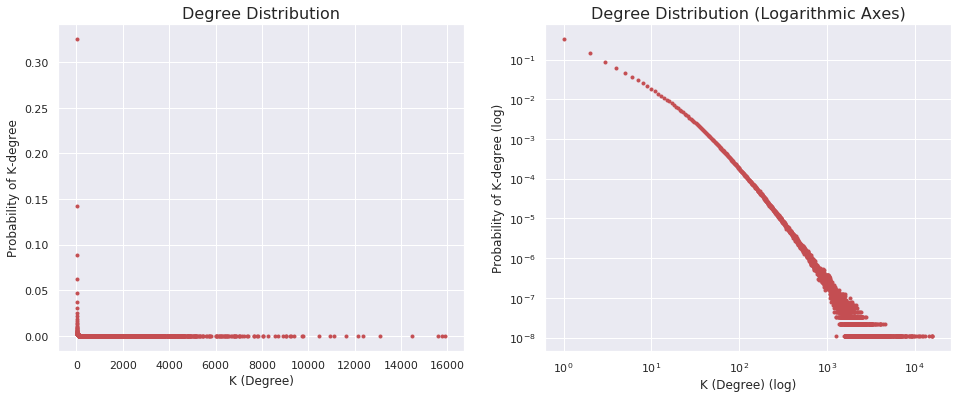

In [12]:
plot_degree_distribution(x, y, "degree_distribution_2.png")

The cleanup process made the upper boundary way lower than before though.

# 6. Connected Components
Due to the nature and the size of the network, it's very unlikely that it's fully connected. Worth reminding that in the context of *undirected* networks, it's enough to simply say *connected* rather than *strongly/weakly* connected.

In [24]:
print("Is the network connected? {0}".format(snap.IsConnected(graph)))

Is the network connected? False


It would be interesting to plot the **distribution of the connected components sizes**. The obtained distribution would consist of a vector of pairs, where in each pair the first element indicates the *size* of the components and the second one the number of components of that size.

In [13]:
def get_connected_components_distribution(graph):
    ComponentDist = snap.TIntPrV()
    snap.GetSccSzCnt(graph, ComponentDist)
    return ComponentDist

def plot_connected_components_distribution(distribution, fig_filename, remove_biggest_component=False):
    sizes_x = [el.GetVal1() for el in distribution]
    frequency_y = [el.GetVal2() for el in distribution]
    if remove_biggest_component:
        sizes_x = sizes_x[:-1]
        frequency_y = frequency_y[:-1]
    plt.figure(figsize=(16,6))

    # First subplot: normal axes
    plt.subplot(1,2,1)
    plt.xlabel("Component Size")
    plt.ylabel("Frequency")
    plt.plot(sizes_x,frequency_y,"r.")
    plt.title("Components Sizes Distribution", fontsize=16)

    # Second subplot: logarithmic axes
    plt.subplot(1,2,2)
    plt.xlabel("Component Size (log)")
    plt.ylabel("Frequency (log)")
    plt.loglog(sizes_x, frequency_y, "r.")
    plt.title("Components Sizes Distribution (Logarithmic Axes)", fontsize=16)
    
    # Save and show figure
    plt.savefig(os.path.join(pictures_path,fig_filename))
    plt.show()

In [14]:
ComponentDist = get_connected_components_distribution(graph)

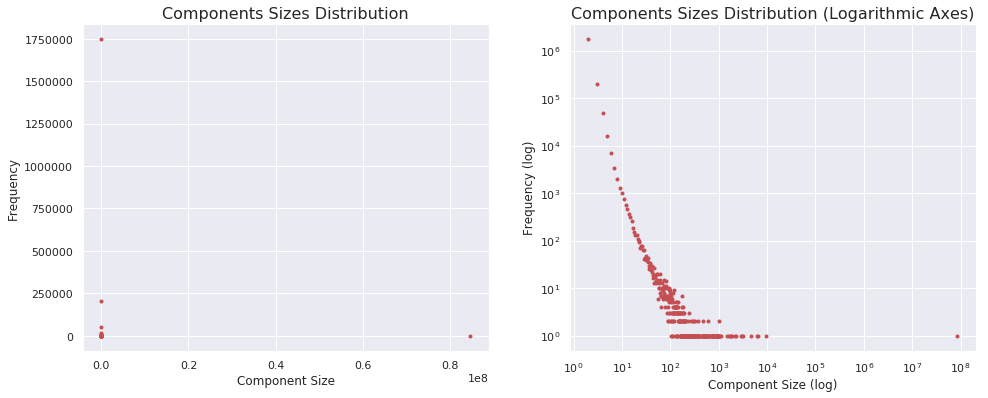

In [15]:
plot_connected_components_distribution(ComponentDist, "connected_components_distribution.png")

The above results shows that the network is mostly connected, with the biggest connected component that has size in the order of $10^8$, which means it basically contains the vast majority of the nodes of the network. The biggest component is indeed an outlier in the above plots, so I may just provide an alternative visualization where I filter it out to better see the size distribution of the smaller components.

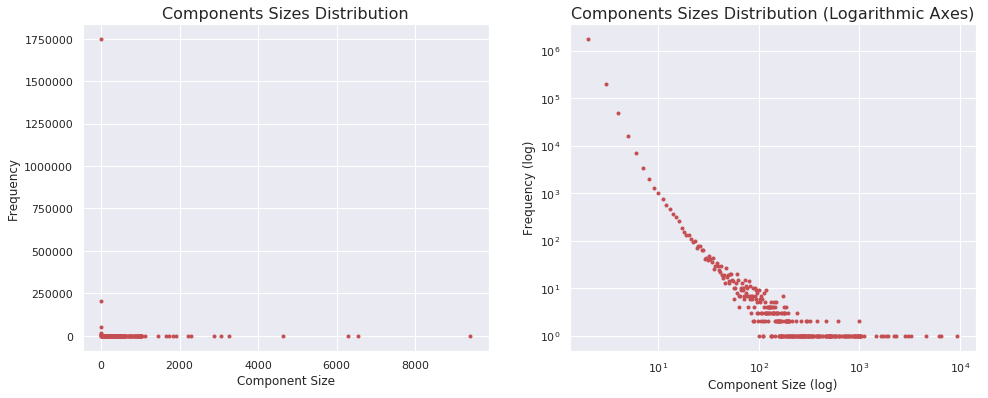

In [16]:
plot_connected_components_distribution(ComponentDist, "connected_components_distribution_no_biggest.png", remove_biggest_component=True)

In [56]:
# Get size of biggest component
total_nodes_biggest_component = 84510806 # From the distribution above
total_nodes_minor_components = sum([el.GetVal1() * el.GetVal2() for el in ComponentDist if el.GetVal1() != total_nodes_biggest_component])
assert total_nodes_minor_components == N - total_nodes_biggest_component

In [62]:
print("Total nodes in minor components: %d" % total_nodes_minor_components)
print("Relative size (in percentage) compared to the total: %.2f%%" % (((1.0*total_nodes_minor_components)/N)*100))

Total nodes in minor components: 4744140
Relative size (in percentage) compared to the total: 5.32%


According to the above plot, it's clear that the size of a component is indirectly proportional to the amount of nodes it contains.

If we look at the number of components of size 2, which is $comp_2=1.747.089$, we would realize that there are $2*comp_2$ nodes (**~3,91%** of the total nodes in the network, which is relatively high) such that for example nodes $x$ and $y$ are connected to each other and not to any other node in the network. By the other side, the biggest connected component, $comp_{84510806}$, includes **84.510.806** nodes (**~94,7%** of the total). Because of this, I consider reasonable enough to restrict our analysis to the biggest connected component, and filter out all the smaller ones. Furthermore, there's a jump of **4 magnitude orders** (in base 10) from the size of the biggest connected component to the size of second biggest one. Overall, all the components beside the biggest one represent a total amount of nodes which is represented by:
$$comp_2*2 + comp_3*3 + comp_4*4 + \dots + comp_{9397}*9397 = 4.744.140$$

This means that *only* **5.32%** of the nodes in the whole network are part of smaller components, out of which **~37%** are part of a component of size 2. With these stats, it's safe enough to state that the smaller components may be excluded from the analysis without significant consequences.

Let's therefore **restrict our main network to the biggest connected component**.

## 6.1 Biggest Connected Component Properties
Now that we have a *connected* graph, let's see how do the basic network properties change:

In [64]:
graph_connected = snap.GetMxScc(graph)

In [71]:
# Backup Max Connected Component
FOut = snap.TFOut("../data/mmr_max_connected_component.bin")
graph_connected.Save(FOut)
FOut.Flush()

# Load again from below snippet
'''
FIn = snap.TFIn("../data/mmr_max_connected_component.bin")
graph_connected = snap.TUNGraph.Load(FIn)
'''

In [3]:
N_maxcc = graph_connected.GetNodes()
L_maxcc = graph_connected.GetEdges()
K_maxcc = (2.0 * L_maxcc)/N_maxcc

In [4]:
print("Nodes in Max connected component: %d" %(graph_connected.GetNodes()))
print("Edges in Max connected component: %d" %(graph_connected.GetEdges()))
print("Average degree in Max connected component: %.3f" % K_maxcc)

Nodes in Max connected component: 84510806
Edges in Max connected component: 427935499
Average degree in Max connected component: 10.127


| Property | Full MMR (Before Cleanup) | Full MMR (After Cleanup) | Max Connected Component | Difference\* | Difference (Percentage)
|---|---|---|---|---|---|
| **Average Degree $\langle K \rangle$** | 9,694 | 9,7 | 10,127 | ~0.433 | ~4,46%
| **Number of nodes $N$** | 89.577.277 | 89.254.946 | 84.510.806 | **5.066.471** | ~5,65%
| **Number of edges $L$** | 434.193.958 | 432.872.203 | 427.935.499 | **6.258.459** | ~1,44%

\* *It's meant to be the difference of the property compared to the original graph*.

As we can see from the above progression, only the number of nodes and the average degree have been affected by a slightly meaningful change, whereas the number of edges is still very high compared to the original graph.